# Ensemble Xgb

## Import Package


In [2]:
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import xgboost as xgb

In [4]:
from utils.metrics import evaluate

## Const & Inputs

Here are all of the parameters to change for the run.


In [5]:

# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# Number of classes in the dataset
num_classes = 33

# Models for ensemble
train_models = [
    {
        'name': 'bit',
        'path': 'BiT-M-R50x1_batch256_lr0.0003_fullset_v2'
    }, 
    {
        'name': 'efficientnet',
        'path': 'fullset_224_crop70xy_correct_by_rule_efficientnetb3_transfer_trainable_epochs100_batchsize64_lr0.0005_reducelr_dropout40'
    }, 
    {
        'name': 'dcnnlh',
        'path': 'DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-hmConcat-270rotate-low-high-85'
    }, 
    {
        'name': 'convnextsmalllh',
        'path': 'convnextSmall-adamW-labelSmoothing-270rotate-low-high-85'
        # 'name': 'convnextbaselh',
        # 'path': 'convnextBase-adamW-labelSmoothing-270rotate-low-high-85'
    }, 
    {
              'name': 'convnextbaselh',
        'path': 'convnextBase-adamW-labelSmoothing-270rotate-low-high-85'
    }
]

public_models = [
    {
        'name': 'bitcrop100',
        'path': 'BiT-M-R152x2_batch256_lr0.0003_fullset_crop_data2_oriSize_public_submission'
    }, 
    {
        'name': 'efficientnet85',
        'path': 'fullset_224_crop70xy_correct_by_rule_efficientnetb3_transfer_trainable_epochs100_batchsize64_lr0.0005_reducelr_dropout40'
    }, 
    {
        'name': 'dcnnlh85',
        'path': 'DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-hmConcat-270rotate-low-high-85'
    }, 
    {
        'name': 'convnextbaselh100',
        'path': 'convnextBase-adamW-labelSmoothing-270rotate-low-high-100'
        # 'name': 'convnextbaselh85',
        # 'path': 'convnextBase-adamW-labelSmoothing-270rotate-low-high-85'
    }, 
]

private_models = [
    {
        'name': 'bitcrop100',
        'path': 'BiT-M-R152x2_batch256_lr0.0003_fullset_crop_data2_oriSize_private_submission'
    }, 
    {
        'name': 'efficientnet85',
        'path': 'fullset_224_crop70xy_correct_by_rule_efficientnetb3_transfer_trainable_epochs100_batchsize64_lr0.0005_reducelr_dropout40'
    }, 
    {
        'name': 'dcnnlh85',
        'path': 'private-dcnn2-feature4-conv14-he_uniform-adam-labelSmoothing-hmConcat-270rotate-low-high-85'
    }, 
    {
        # 'name': 'convnextbaselh85',
        # 'path': 'private-convnextBase-adamW-labelSmoothing-270rotate-low-high-85'
        'name': 'convnextbaselh100',
        'path': 'private-convnextBase-adamW-labelSmoothing-270rotate-low-high-100'
    }, 
]


## Helper

In [6]:
def apply_inductive_rules(label, county_name, town_name, full_rules, threshold=1):
    inductive_label = ""
    rules = full_rules.copy()
    rules = rules[rules['label_percentage_in_town'] >= threshold].reset_index(drop=True)
    for i, rule in rules.iterrows():
        if(rule['county_name'] == county_name and rule['town_name'] == town_name):
            inductive_label = rule['label']
    return inductive_label if inductive_label else label

In [7]:
def apply_exclusion_rules(label_prob, county_name, town_name, full_rules, threshold=0.0):
    exclusion_prob = label_prob.copy()
    rules = full_rules.copy()
    rules = rules[rules['county_name'].eq(county_name) & rules['town_name'].eq(town_name)].sort_values(by=['label'], ascending=True, ignore_index=True)
    rules = rules[rules['town_percentage_in_label'] <= threshold]
    excluded_indices = rules.index.tolist()
    exclusion_prob[excluded_indices] = 0
    return exclusion_prob

In [8]:
def build_x_y(df, models, list_of_use_models, num_classes=num_classes):
    # Build inputs of prob from each model
    x = np.concatenate([
        np.array(df[f'predict_{models[i]["name"]}'].tolist()).reshape(-1, num_classes) for i in list_of_use_models
    ], axis=1)
    y = np.array(df['class'].tolist())
    return x, y

In [9]:
def initialize_model(params, num_classes):
    # Initialize these variables which will be set in this if statement, each of these variables is model specific.
    model_ft = xgb.XGBClassifier(**params)
    return model_ft

## Data Preprocessing

### Load Data

Load the prediction results of 3 models and merge into a DataFrame.

In [10]:
data = pd.read_pickle(F'{path}/data/train_split_fullset.pkl').sort_values(by=['file']).reset_index(drop=True)

# Copy result from each model
for i in range(len(train_models)):
    result = pd.read_pickle(F'{path}/outputs/train/{train_models[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    data[f'predict_{train_models[i]["name"]}'] = result['predict']
    data[f'predict_label_{train_models[i]["name"]}'] = result['predict_label']

### Encode categorical features

LabelEncoder


In [11]:
from sklearn.preprocessing import LabelEncoder
# Class for label
labelenc = LabelEncoder()
labelenc.fit(data['label'].values)
data['class'] = labelenc.transform(data['label'].values)

### Split Data

Split data into train, validation and test sets.


In [17]:
train = data[data['set_name'].eq('train') | data['set_name'].eq('test')].reset_index(drop=True)
valid = data[data['set_name'].eq('valid')].reset_index(drop=True)
# Generate test from valid(8:2)
# valid['test_in_valid'] = np.nan
# valid.groupby(['label', 'county_name']).apply(lambda x: valid["test_in_valid"].fillna(pd.Series(data=1, index=x.sample(frac=0.20, random_state=5397).index), inplace=True))
# test = valid[valid['test_in_valid'].eq(1)].reset_index(drop=True)
# valid = valid[~valid['test_in_valid'].eq(1)].reset_index(drop=True)
# print(F"data: {data.shape}, train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

Evaluate each model on train

In [13]:
for i in range(len(train_models)):
    evaluation = pd.DataFrame(evaluate(train['label'].tolist(), train[f'predict_label_{train_models[i]["name"]}'].tolist())).T
    print(train_models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

bit 0.9483
efficientnet 0.9265
dcnnlh 0.9991
convnextsmalllh 0.9992
convnextbaselh 0.9994


Evaluate each model on valid

In [18]:
for i in range(len(train_models)):
    evaluation = pd.DataFrame(evaluate(valid['label'].tolist(), valid[f'predict_label_{train_models[i]["name"]}'].tolist())).T
    print(train_models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

bit 0.8769
efficientnet 0.7614
dcnnlh 0.7694
convnextsmalllh 0.8383
convnextbaselh 0.8626


### Prepare X and Y
Train the model using predicted probabilities.

In [14]:
# Build x, y for model
x_valid, y_valid = build_x_y(valid, train_models, range(len(train_models)))
x_test, y_test = build_x_y(test, train_models, range(len(train_models)))

## Classification Prediction
Based on the output proba of each model.

#### Basic

In [22]:
# Print the new model set
model_set = '-'.join([train_models[i]["name"] for i in range(len(train_models))])

with open(F'{path}/models/ensemble-xgb-bit-efficientnet-dcnnlh-convnextsmalllh-hyperopt1000-params.json') as f:
    best_params = json.load(f)
    
# Create model & train
clf = initialize_model(best_params, num_classes)
clf.fit(x_valid, y_valid)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=9.606416804212778, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0449954462199561,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=16.0,
              max_depth=12, max_leaves=0, min_child_weight=4.0, missing=nan,
              monotone_constraints='()', n_estimators=1100, n_jobs=0,
              num_class=33, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, ...)

In [21]:
# Predict the response for test dataset
test['proba'] = list(clf.predict_proba(x_test))

# Transform the encoded predictions to their actual values
test['predict_label'] = test['proba'].apply(lambda x: np.argmax(x))
test['predict_label'] = labelenc.inverse_transform(test['predict_label'])

# Evaluate the model
evaluation = evaluate(test['label'].tolist(), test['predict_label'].tolist())
print('weighted precision:', round(pd.DataFrame(evaluation).T['precision']['weighted avg'], 5))  

weighted precision: 0.9069


#### Hyperparameter Optimization

In [25]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.iteration = 0
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo,
                          max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return {'result': result, 'history': trials}

    def xgb_clf(self, para):
        clf = xgb.XGBClassifier(**para['clf_params'])
        return self.train_clf(clf, para)

    def train_clf(self, clf, para):
        self.iteration += 1
        time_start = time.time()
        clf.fit(
            self.x_train, self.y_train,
            **para['fit_params']
        )
        pred = clf.predict(self.x_test)
        time_end = time.time()
        run_time = time_end - time_start

        loss = para['loss_func'](self.y_test, pred)
        return {'iteration': self.iteration, 'loss': loss, 'train_time': run_time, 'params': para, 'status': STATUS_OK}

In [23]:
# from hyperopt.pyll.stochastic import sample
# sample(scope.int(hp.quniform('example', 0, 10, 1)))
# Returns an integer from 0 to 10, inclusive

In [26]:
from hyperopt.pyll.base import scope

xgb_para = dict()
xgb_para['clf_params'] = {
    'objective':        'multi:softproba',   
    'num_class':        num_classes,
    'tree_method':      'gpu_hist', 
    'gpu_id':           0,
    'eval_metric':      'auc',
    'booster':          'gbtree',
    'n_estimators':     scope.int(hp.quniform('n_estimators', 200, 1500, 100)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'gamma':            hp.uniform ('gamma', 0.0, 10.0), # min_split_loss
    'max_depth':        scope.int(hp.quniform('max_depth', 1, 20, 2)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'max_delta_step':   hp.quniform('max_delta_step', 0, 20, 2),
    'subsample':        hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha':        hp.uniform('reg_alpha', 0.1, 1.0),  # L1 regularization
    'reg_lambda':       hp.uniform('reg_lambda', 0.0, 1.0), # L2 regularization
}
xgb_para['fit_params'] = {}
xgb_para['loss_func'] = lambda y, pred: -evaluate(y.tolist(), pred.tolist())['weighted avg']['f1-score']

bit-efficientnet-dcnnlh-convnextlhbase
100%|██████████| 1000/1000 [10:18:21<00:00, 37.10s/trial, best loss: -0.9047954302750191]  


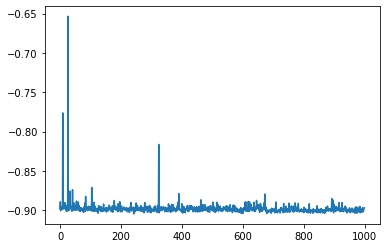

In [27]:
iteration = 1000

# Obtain all models index
list_of_use_models = [i for i in range(len(train_models))]
    
# Print model set
model_set = '-'.join([train_models[i]["name"] for i in list_of_use_models])
print(model_set)

# Build x, y for model
x_valid, y_valid = build_x_y(valid, train_models, list_of_use_models)
x_test, y_test = build_x_y(test, train_models, list_of_use_models)
    
# Init
obj = HPOpt(x_valid, x_test, y_valid, y_test)

# Run optimization
trials = Trials()
opt = obj.process(fn_name='xgb_clf', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=iteration)

# Show best params 
history = pd.DataFrame(opt['history'].results)
best_params = history.loc[history['loss'].idxmin()]['params']['clf_params']

# Save best params
with open(F'{path}/models/ensemble-xgb-{model_set}-xyz-hyperopt{iteration}-params.json', 'w') as f:
    json.dump(best_params, f)
history.to_csv(F'{path}/logs/ensemble-xgb-{model_set}-xyz-hyperopt{iteration}.csv')

# Drow loss
plt.plot(history['loss'])

View hyperparameters versus time

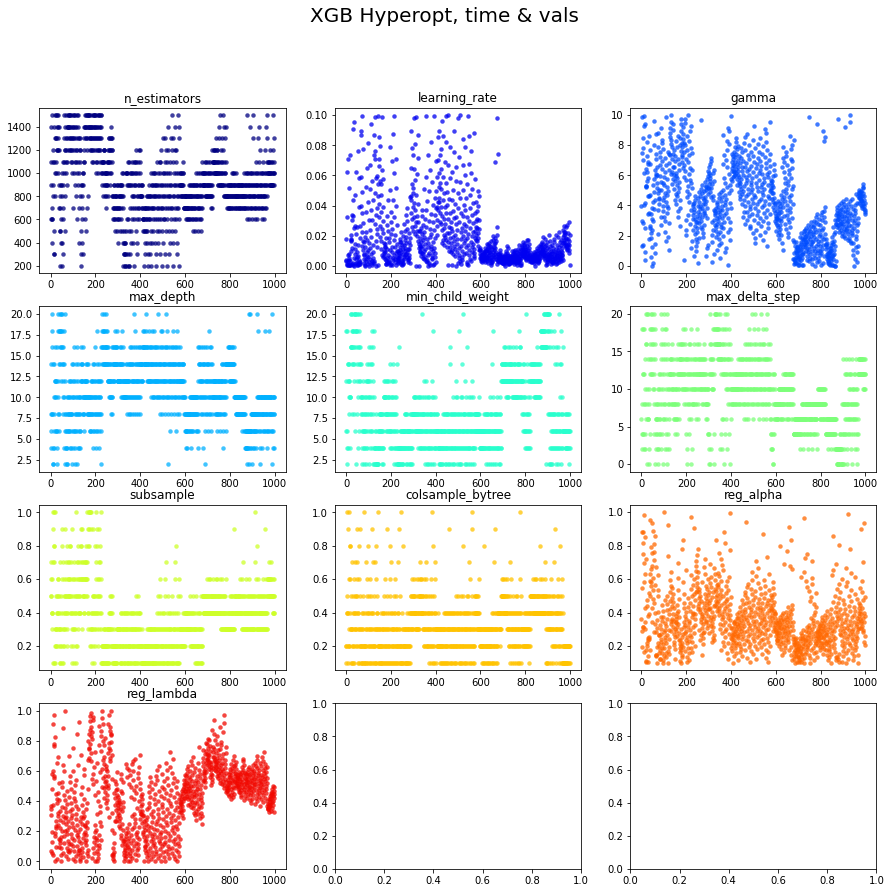

In [30]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, time & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['tid'] for t in trials.trials]).ravel()
    ys = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

View relationship between hyperparameters and loss

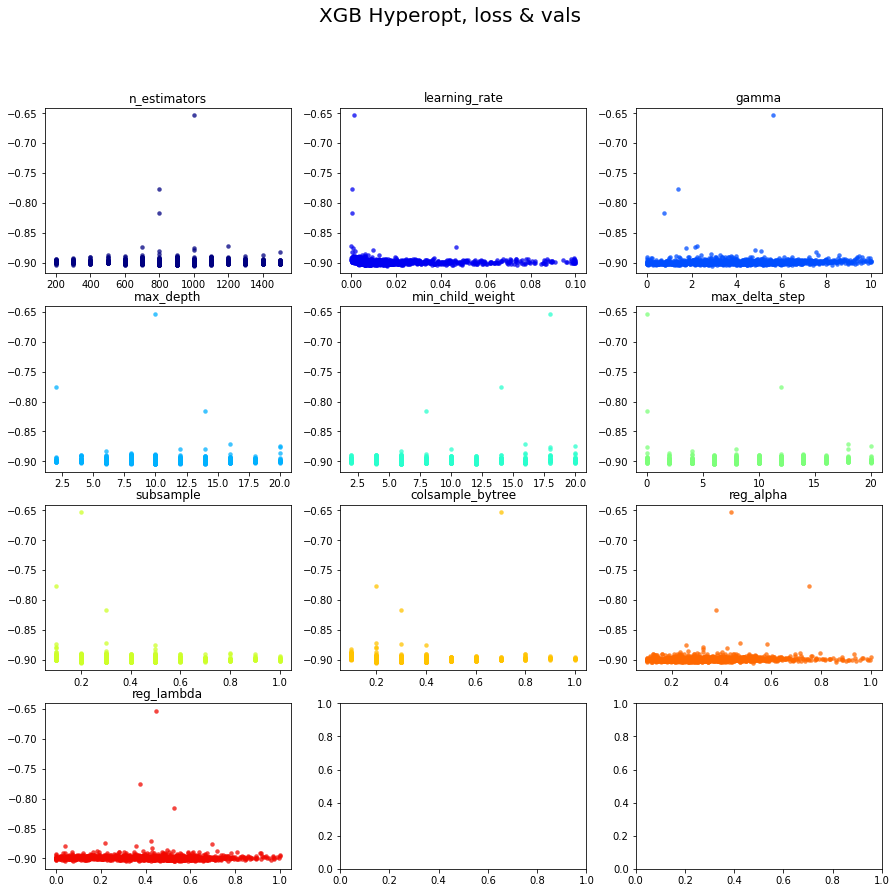

In [31]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, loss & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

## Submission


In [12]:
# label_percentage_in_town => inductive_threshold will apply rules
inductive_threshold = 1.0

# town_percentage_in_label <= exclusion_threshold will apply rules
exclusion_threshold = 0.0

# analysis
train_label_town_percentage = pd.read_csv(F'{path}/analysis/train_label_town_percentage.csv')
train_label_town_percentage.head(3)

,label,county_name,town_name,counts,town_percentage_in_label,label_percentage_in_town
0,asparagus,彰化縣,二林鎮,898.0,0.43998,0.222829
1,asparagus,新竹市,東區,5.0,0.00245,0.025773
2,asparagus,屏東縣,枋寮鄉,0.0,0.00000,0.000000


Load Public Output

In [14]:
# Read basic information of dataset
public = pd.read_csv(f'{path}/data/public_tag_loc_coor_describe_elevation.csv').sort_values(by=['file']).reset_index(drop=True)
public = public.rename(columns={'file': 'filename'})
public['class'] = np.nan

# Copy result from each model
for i in range(len(public_models)):
    result = pd.read_pickle(F'{path}/outputs/public/{public_models[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    public[f'predict_{public_models[i]["name"]}'] = result['predict']
    public[f'predict_label_{public_models[i]["name"]}'] = result['predict_label']

Load Private Output

In [15]:
# Read basic information of dataset
private = pd.read_csv(f'{path}/data/private_tag_loc_coor_describe_elevation.csv').sort_values(by=['file']).reset_index(drop=True)
private = private.rename(columns={'file': 'filename'})
private['class'] = np.nan

# Copy result from each model
for i in range(len(private_models)):
    result = pd.read_pickle(F'{path}/outputs/private/{private_models[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    private[f'predict_{private_models[i]["name"]}'] = result['predict']
    private[f'predict_label_{private_models[i]["name"]}'] = result['predict_label']

Check Model Set

In [16]:
# Print model set
train_model_set = '-'.join([train_models[i]["name"] for i in range(len(train_models))])
public_model_set = '-'.join([public_models[i]["name"] for i in range(len(public_models))])
private_model_set = '-'.join([private_models[i]["name"] for i in range(len(private_models))])
print('train model set:', train_model_set)
print('public model set:', public_model_set)
print('private model set:', private_model_set)

train_model_set: bit-efficientnet-dcnnlh-convnextsmalllh
public_model_set: bitcrop100-efficientnet85-dcnnlh85-convnextbaselh100
private_model_set: bitcrop100-efficientnet85-dcnnlh85-convnextbaselh100


### Normal

In [21]:
# Build x, y for model
x_public, y_public = build_x_y(public, public_models, range(len(public_models)))
x_private, y_private = build_x_y(private, private_models, range(len(private_models)))

with open(F'{path}/models/ensemble-xgb-bit-efficientnet-dcnnlh-convnextsmalllh-hyperopt1000-params.json') as f:
    best_params = json.load(f)

# Create the model [LightGBM, XGBoost]
clf = initialize_model(best_params, num_classes)
# clf.fit(x_valid, y_valid)
# clf.save_model(F"{path}/models/ensemble-xgb-{train_model_set}-hyperopt-{iteration}-model.json")

# load model
clf.load_model(F"{path}/models/ensemble-xgb-bit-efficientnet-dcnnlh-convnextsmalllh-hyperopt1000-model.json")

In [22]:
# Public: Predict the response for test dataset
public['proba'] = list(clf.predict_proba(x_public))

# Private: Predict the response for test dataset
private['proba'] = list(clf.predict_proba(x_private))

# Public: Inverse Transform
public['label'] = public['proba'].apply(lambda x: np.argmax(x))
public['label'] = labelenc.inverse_transform(public['label'])

# Private: Inverse Transform
private['label'] = private['proba'].apply(lambda x: np.argmax(x))
private['label'] = labelenc.inverse_transform(private['label'])

In [ ]:
# Public: Apply Exclusion Rules
# public['proba_exclusion'] = public.apply(lambda row: apply_exclusion_rules(row['proba'], row['county_name'], row['town_name'], train_label_town_percentage, exclusion_threshold), axis=1)
# public['label_exclusion'] = public['proba_exclusion'].apply(lambda x: np.argmax(x))
# public['label_exclusion'] = labelenc.inverse_transform(public['label_exclusion'])
# print('exclusion counts:', len(public[public['label'] != public['label_exclusion']]))
# exclusion 0.0 = 73 counts

In [24]:
# # Public: Apply Inductive Rules
# public['label_inductive'] = public.apply(lambda row: apply_inductive_rules(row['label'], row['county_name'], row['town_name'], train_label_town_percentage, inductive_threshold), axis=1)
# print('public inductive counts:', len(public[public['label'] != public['label_inductive']]))
# # inductive 0.90 = 10 counts
# # inductive 0.91 = 10 counts
# # inductive 0.92 =  1 counts
# # inductive 0.93 =  1 counts
# # inductive 0.94 =  1 counts
# # inductive 0.95 =  0 counts
# # inductive 1.0  =  0 counts

# # Private: Apply Inductive Rules
# private['label_inductive'] = private.apply(lambda row: apply_inductive_rules(row['label'], row['county_name'], row['town_name'], train_label_town_percentage, inductive_threshold), axis=1)
# print('private inductive counts:', len(private[private['label'] != private['label_inductive']]))
# # inductive 0.92 =  2 counts
# # inductive 0.93 =  2 counts
# # inductive 0.94 =  2 counts
# # inductive 0.95 =  0 counts
# # inductive 1.0  =  0 counts

public inductive counts: 1
private inductive counts: 2


In [25]:
# Public: Submission
public[['filename', 'label']].to_csv(F'{path}/submission/public/xgb-{train_model_set}-hyperopt{1000}-{public_model_set}.csv', index=False)   

# Private: Submission
private[['filename', 'label']].to_csv(F'{path}/submission/private/xgb-{train_model_set}-hyperopt{1000}-{private_model_set}.csv', index=False)     

### Public + Private 

In [57]:
# public_submission = pd.read_csv(F'{path}/submission/public/xgb-bit-efficientnet-dcnnlh-convnextsmalllh-hyperopt1000-bitcrop100-efficientnet85-dcnnlh85-convnextbaselh100.csv')
# private_submission = pd.read_csv(F'{path}/submission/private/xgb-bit-efficientnet-dcnnlh-convnextsmalllh-hyperopt1000-bitcrop100-efficientnet85-dcnnlh85-convnextbaselh100.csv')

In [13]:
# public_and_private = pd.concat([public_submission, private_submission], axis=0).reset_index(drop=True)
# public_and_private.to_csv(F'{path}/submission/public_and_private/xgb-bit-efficientnet-dcnnlh-convnextsmalllh-hyperopt1000-bitcrop100-efficientnet85-dcnnlh85-convnextbaselh100-inductive-94.csv', index=False)